In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pandas as pd
import PIL
from PIL import Image
import numpy as np

from tqdm import tqdm

In [ ]:
train_dir = 'src/archive/train'
test_dir = 'src/archive/test'

dataset = datasets.ImageFolder(root = "archive (1)")

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels = 1),
    transforms.Resize((48,48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = datasets.ImageFolder(root = train_dir, transform = transform)
test_dataset = datasets.ImageFolder(root = test_dir, transform = transform)

print(train_dataset.class_to_idx)
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = True)


for image, label in (train_loader):
    print(image.shape)
    print(label.shape)
    break

{'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}
torch.Size([64, 1, 48, 48])
torch.Size([64])


In [5]:
class CNNEmotion(nn.Module):
    def __init__(self):
        super(CNNEmotion, self).__init__()
        self.conv1 = nn.Conv2d(1,64, kernel_size =3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size =3)
        self.fc1 = nn.Linear(12800,512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 6)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.flatten(1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
device = "cuda"
model = CNNEmotion().to(device)

print(model(torch.randn(1, 1, 48, 48).to(device)).shape)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr =2e-4)

num_epochs = 25
train_losses = []
val_losses = []
train_accuracys = []
val_accuracys = []

for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0
    correct = 0
    total = 0
    model.train()

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    accuracy = 100*(correct/total)
    train_losses.append(train_loss)
    train_accuracys.append(accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for val_images, val_labels in test_loader:
            val_images = images.to(device)
            val_labels = labels.to(device)
            val_outputs = model(val_images)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item()
            

            _, predicted = torch.max(val_outputs.data, 1)
            total+=val_labels.size(0)
            correct+=(predicted == val_labels).sum().item()
    
    val_loss /= len(test_loader)
    val_accuracy = 100*correct/total
    val_losses.append(val_loss)
    val_accuracys.append(val_accuracy)
    
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}%")

torch.Size([1, 6])


  4%|▍         | 1/25 [01:45<42:15, 105.66s/it]

Validation Loss: 1.3775, Validation Accuracy: 38.78%
Epoch [1/25], Loss: 1.5632, Accuracy: 37.22%


  8%|▊         | 2/25 [01:57<19:14, 50.18s/it] 

Validation Loss: 1.2860, Validation Accuracy: 51.02%
Epoch [2/25], Loss: 1.3720, Accuracy: 45.96%


 12%|█▏        | 3/25 [02:10<12:17, 33.52s/it]

Validation Loss: 1.2773, Validation Accuracy: 51.02%
Epoch [3/25], Loss: 1.2837, Accuracy: 50.09%


 16%|█▌        | 4/25 [02:23<08:55, 25.50s/it]

Validation Loss: 1.2693, Validation Accuracy: 57.14%
Epoch [4/25], Loss: 1.2133, Accuracy: 53.01%


 20%|██        | 5/25 [02:37<07:02, 21.12s/it]

Validation Loss: 0.9864, Validation Accuracy: 63.27%
Epoch [5/25], Loss: 1.1518, Accuracy: 55.88%


 24%|██▍       | 6/25 [02:51<05:53, 18.62s/it]

Validation Loss: 1.0959, Validation Accuracy: 57.14%
Epoch [6/25], Loss: 1.0911, Accuracy: 58.55%


 28%|██▊       | 7/25 [03:05<05:08, 17.13s/it]

Validation Loss: 1.0809, Validation Accuracy: 55.10%
Epoch [7/25], Loss: 1.0303, Accuracy: 61.10%


 32%|███▏      | 8/25 [03:18<04:33, 16.11s/it]

Validation Loss: 0.9317, Validation Accuracy: 73.47%
Epoch [8/25], Loss: 0.9695, Accuracy: 63.76%


 36%|███▌      | 9/25 [03:33<04:07, 15.46s/it]

Validation Loss: 0.9544, Validation Accuracy: 69.39%
Epoch [9/25], Loss: 0.9068, Accuracy: 66.41%


 40%|████      | 10/25 [03:47<03:45, 15.01s/it]

Validation Loss: 0.8330, Validation Accuracy: 75.51%
Epoch [10/25], Loss: 0.8408, Accuracy: 68.68%


 44%|████▍     | 11/25 [04:01<03:25, 14.70s/it]

Validation Loss: 0.7118, Validation Accuracy: 73.47%
Epoch [11/25], Loss: 0.7712, Accuracy: 71.89%


 48%|████▊     | 12/25 [04:15<03:08, 14.48s/it]

Validation Loss: 0.4830, Validation Accuracy: 87.76%
Epoch [12/25], Loss: 0.7063, Accuracy: 74.58%


 52%|█████▏    | 13/25 [04:27<02:46, 13.86s/it]

Validation Loss: 0.8159, Validation Accuracy: 73.47%
Epoch [13/25], Loss: 0.6375, Accuracy: 76.99%


 56%|█████▌    | 14/25 [04:39<02:26, 13.33s/it]

Validation Loss: 0.4151, Validation Accuracy: 87.76%
Epoch [14/25], Loss: 0.5783, Accuracy: 79.36%


 60%|██████    | 15/25 [04:53<02:14, 13.50s/it]

Validation Loss: 0.3682, Validation Accuracy: 95.92%
Epoch [15/25], Loss: 0.5188, Accuracy: 81.65%


 64%|██████▍   | 16/25 [05:07<02:03, 13.69s/it]

Validation Loss: 0.3067, Validation Accuracy: 91.84%
Epoch [16/25], Loss: 0.4627, Accuracy: 83.78%


 68%|██████▊   | 17/25 [05:21<01:50, 13.79s/it]

Validation Loss: 0.2288, Validation Accuracy: 95.92%
Epoch [17/25], Loss: 0.4205, Accuracy: 85.34%


 72%|███████▏  | 18/25 [05:35<01:37, 13.86s/it]

Validation Loss: 0.2052, Validation Accuracy: 95.92%
Epoch [18/25], Loss: 0.3697, Accuracy: 87.19%


 76%|███████▌  | 19/25 [05:49<01:23, 13.98s/it]

Validation Loss: 0.2184, Validation Accuracy: 95.92%
Epoch [19/25], Loss: 0.3339, Accuracy: 88.50%


 80%|████████  | 20/25 [06:03<01:09, 13.81s/it]

Validation Loss: 0.1881, Validation Accuracy: 93.88%
Epoch [20/25], Loss: 0.2971, Accuracy: 89.81%


 84%|████████▍ | 21/25 [06:17<00:55, 13.85s/it]

Validation Loss: 0.1281, Validation Accuracy: 95.92%
Epoch [21/25], Loss: 0.2726, Accuracy: 90.66%


 88%|████████▊ | 22/25 [06:31<00:41, 13.94s/it]

Validation Loss: 0.0918, Validation Accuracy: 100.00%
Epoch [22/25], Loss: 0.2416, Accuracy: 91.90%


 92%|█████████▏| 23/25 [06:45<00:27, 13.88s/it]

Validation Loss: 0.1263, Validation Accuracy: 95.92%
Epoch [23/25], Loss: 0.2287, Accuracy: 92.27%


 96%|█████████▌| 24/25 [06:59<00:13, 13.90s/it]

Validation Loss: 0.0597, Validation Accuracy: 97.96%
Epoch [24/25], Loss: 0.2037, Accuracy: 93.12%


100%|██████████| 25/25 [07:12<00:00, 17.32s/it]

Validation Loss: 0.0853, Validation Accuracy: 97.96%
Epoch [25/25], Loss: 0.1907, Accuracy: 93.66%


In [7]:
torch.save(model, "cnn1.pth")

In [10]:
torch.save(model.state_dict(), "cnn2.pth")

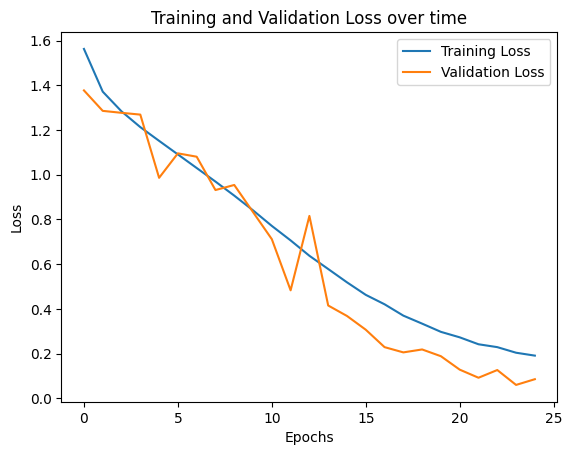

In [8]:
plt.plot(train_losses, label = "Training Loss")
plt.plot(val_losses, label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over time")
plt.legend()
plt.show()



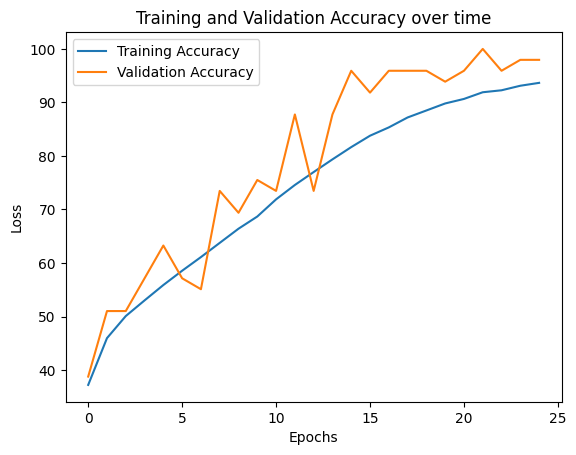

In [9]:
plt.plot(train_accuracys, label = "Training Accuracy")
plt.plot(val_accuracys, label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Accuracy over time")
plt.legend()
plt.show()

